# Monte Carlo Simulation

## Dependencies

In [26]:
import random
from typing import List
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

## Simulation function

Whenever we check the efficiency of a particular batch_size:
 - We decide if a subject is infected or by a probability samplied from (0.001, 0.1) range.
 - We split all the subjects in batches.
 - If there is any infected subject in the batch then we will consider to test them all.
 - If there is no infected subject in a batch then we consider we have done only one test.

In [27]:
def get_random_infection_probability() -> float:
    return random.uniform(0.0001, 0.1)

def simulate(N, batch_size):
    actual_truth: List[bool] = [True if np.random.uniform() < get_random_infection_probability() else False for _ in range(N)]
    batches: List[List[bool]] = [actual_truth[index:index + batch_size] for index in range(0, N, batch_size)]
    
    number_of_tests = 0
    for batch in batches:
        if any(batch):
            number_of_tests += batch_size
        else:
            number_of_tests += 1
    
    return number_of_tests

## Monte carlo sampling

We consider `N` subjects and `number_of_trials` trials for sampling a `batch_size` from the interval of [1, N/2].
 - I decided to make the upper end for the batch_size to be equal to N/2 just to exclude those batch sizes that would definitely not be a viable choice.

In [28]:
N = 10_000
number_of_trials = 10_000

def get_random_batch_size(N) -> int:
    return int(random.uniform(1, N))

necessary_tests_per_batch_size = defaultdict(list)
for trial in range(number_of_trials):
    chosen_batch_size = get_random_batch_size(N / 2)
    result = simulate(N, chosen_batch_size)
    necessary_tests_per_batch_size[chosen_batch_size].append(result)

## Results

### Number of tests per batch size

 - The threshold for number of tests to be conducted is number_of_tests = `N` for `batch_size` = 1.
 - We are searching for the value that minimizes the number of tests.
 - We observe that for relatively big `batch_size`s the number of tests is bigger than the threshold.

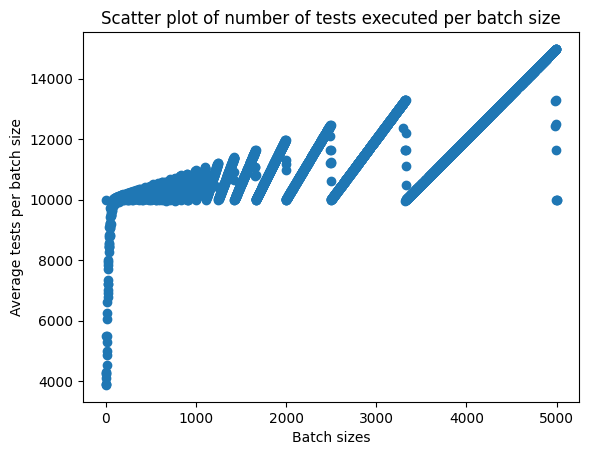

In [29]:
average_tests_per_batch_size_dictionary = {key: np.mean(value) for key, value in necessary_tests_per_batch_size.items()}
batch_sizes = list(average_tests_per_batch_size_dictionary.keys())
average_tests_per_batch_size = list(average_tests_per_batch_size_dictionary.values())

plt.scatter(batch_sizes, average_tests_per_batch_size)
plt.xlabel('Batch sizes')
plt.ylabel('Average tests per batch size')
plt.title('Scatter plot of number of tests executed per batch size')
plt.show()

### Expected reduction in workload

 - The heuristic we use for this case is the `average_tests_per_batch_size` / `N`, where N is the threshold number of tests we would need to do if we test each subject individually.
 - The heuristic result should be interpreted as: What is the percentage of number of tests with respect to `N` that we need to do under a particular `batch_size`

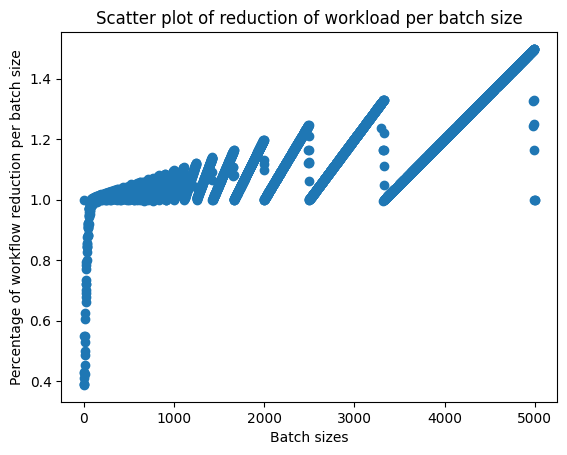

In [30]:
expected_reduction_in_workload_per_batch_size_dictionary = {key: value / N for key, value in average_tests_per_batch_size_dictionary.items()}

batch_sizes = list(expected_reduction_in_workload_per_batch_size_dictionary.keys())
expected_reduction_in_workload_per_batch_size = list(expected_reduction_in_workload_per_batch_size_dictionary.values())

plt.scatter(batch_sizes, expected_reduction_in_workload_per_batch_size)
plt.xlabel('Batch sizes')
plt.ylabel('Percentage of workflow reduction per batch size')
plt.title('Scatter plot of reduction of workload per batch size')
plt.show()

### Best batch size under the particular experimental setup

In [31]:
min_pair = min(expected_reduction_in_workload_per_batch_size_dictionary.items(), key=lambda x: x[1])
print(f"Best batch_size={min_pair[0]} => implies that we should be conducting only {min_pair[1] * 100}% number_of_tests with respect to N")

Best batch_size=5 => implies that we should be conducting only 38.72% number_of_tests with respect to N


# Q learning versus SARSA

## Dependencies

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Helpers

In [33]:
ROWS=4
COLUMNS=21

START = "S"
GOAL = "G"
CLIFF = "C"
SNAKE_PIT = "P"

UP = "^"
DOWN = "v"
RIGHT = ">"
LEFT = "<"
ACTIONS = [UP, DOWN, RIGHT, LEFT]
ACTION_POSITION_MAPPER = {
    UP: (-1, 0),
    RIGHT: (0, 1),
    DOWN: (1, 0),
    LEFT: (0, -1)
}

START_POSITION = (3, 0)
GOAL_POSITION = (3, 20)
SNAKE_PIT_POSITION = (0, 11)
CLIFF_POSITIONS = [(3, cliff_column_index) for cliff_column_index in range(1, COLUMNS - 1)]

def get_world(with_snake_pit):
    world = [[random.choice(ACTIONS) for _ in range(COLUMNS)] for _ in range(ROWS)]
    
    world[START_POSITION[0]][START_POSITION[1]] = START
    world[GOAL_POSITION[0]][GOAL_POSITION[1]] = GOAL
    
    if with_snake_pit:
        world[SNAKE_PIT_POSITION[0]][SNAKE_PIT_POSITION[1]] = SNAKE_PIT

    for cliff_position in CLIFF_POSITIONS:
       world[cliff_position[0]][cliff_position[1]] = CLIFF
    
    return world

def print_world(world):
    for row in world:
        print(" ".join(row))

def choose_action(Q, new_state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return random.choice(ACTIONS)
    else:
        actions_utilities = Q[new_state]
        return ACTIONS[np.argmax(actions_utilities)]

def get_start_state():
    return START_POSITION

def get_new_state(current_state, action):
  position_updater = ACTION_POSITION_MAPPER[action]
  new_state = (current_state[0] + position_updater[0], current_state[1] + position_updater[1])
  
  # row invalidation
  if new_state[0] < 0 or new_state[0] > ROWS - 1:
     return current_state
  
  # column invalidation
  if new_state[1] < 0 or new_state[1] > COLUMNS - 1:
    return current_state

  return new_state

def final_state(state):
    return state == GOAL_POSITION or state in CLIFF_POSITIONS

def get_reward(position, with_snake_pit):
    if position == GOAL_POSITION:
        return 20
    
    if position in CLIFF_POSITIONS:
        return -100
    
    if with_snake_pit and position in SNAKE_PIT_POSITION:
        return -100
    
    return -1

## Sarsa implementation

In [34]:
def run_sarsa(epochs = 2000, epsilon=0, with_snake_pit=False, alpha = 0.1, gamma = 0.9):
  Q = {(i,j):[0, 0 ,0 , 0] for i in range(ROWS) for j in range(COLUMNS)}

  rewards_history = []
  for _ in range(epochs):
    current_state = get_start_state()
    current_action = choose_action(Q, current_state, epsilon=epsilon)

    reward_per_epoch = 0  
    while not final_state(current_state):
      new_state = get_new_state(current_state, current_action)
      new_action = choose_action(Q, new_state, epsilon=epsilon)

      reward = get_reward(new_state, with_snake_pit)
      reward_per_epoch += reward

      current_action_index_in_Q = ACTIONS.index(current_action)
      Q_current = Q[current_state][current_action_index_in_Q]
      
      new_action_index_in_Q = ACTIONS.index(current_action)
      Q_next = Q[new_state][new_action_index_in_Q]
      
      Q[current_state][current_action_index_in_Q] = Q_current + (alpha * (reward + gamma * Q_next - Q_current))

      current_state = new_state
      current_action = new_action
    
    rewards_history.append(reward_per_epoch)
  
  return Q, rewards_history

## Q Learning + replay buffer implementation

In [35]:
REPLAY_BUFFER_SIZE = 2048
REPLAY_BUFFER_BATCH_SIZE = 1024

def run_q_learning(epochs = 2000, epsilon=0, replay_buffer_enabled= False, with_snake_pit=False, alpha = 0.1, gamma = 0.9):
  Q = {(i,j):[0, 0 ,0 , 0] for i in range(ROWS) for j in range(COLUMNS)}
  rewards_history = []
  replay_buffer = []
  
  for _ in range(epochs):
    current_state = get_start_state()

    reward_per_epoch = 0  
    while not final_state(current_state):
      current_action = choose_action(Q, current_state, epsilon=epsilon)
      new_state = get_new_state(current_state, current_action)

      reward = get_reward(new_state, with_snake_pit)
      replay_buffer.append((current_state, current_action, reward, new_state))

      if len(replay_buffer) > REPLAY_BUFFER_SIZE:
        replay_buffer.pop(0)

      if replay_buffer_enabled:
        if len(replay_buffer) > REPLAY_BUFFER_BATCH_SIZE:
          buffer_memory = random.sample(replay_buffer, REPLAY_BUFFER_BATCH_SIZE)
          for experience in buffer_memory:
            current_state_history, current_action_history, reward_history, new_state_history = experience
          
            current_action_index_in_Q = ACTIONS.index(current_action_history)
            Q_current = Q[current_state_history][current_action_index_in_Q]
            max_Q_next = max(Q[new_state_history])
            
            Q[current_state_history][current_action_index_in_Q] = Q_current + (alpha * (reward_history + gamma * max_Q_next - Q_current))
      else:
        current_action_index_in_Q = ACTIONS.index(current_action)
        Q_current = Q[current_state][current_action_index_in_Q]
        max_Q_next = max(Q[new_state])
        
        Q[current_state][current_action_index_in_Q] = Q_current + (alpha * (reward + gamma * max_Q_next - Q_current))

      current_state = new_state
      reward_per_epoch += reward
    
    rewards_history.append(reward_per_epoch)
  
  return Q, rewards_history

## Results

### Sarsa with no snake

 - We notice that in this case for smaller epsilon values, the agent manages to find the path to the goal, walking `safe path`.
 - It manages to construct better global policy for smaller epsilon values.
 - As epsilon increases, his exploration increases, and arguably, by change, he just falls down the cliff and ends the episode. That's the reason for some experiments, he didn't manage to construct a good policy to the goal position.

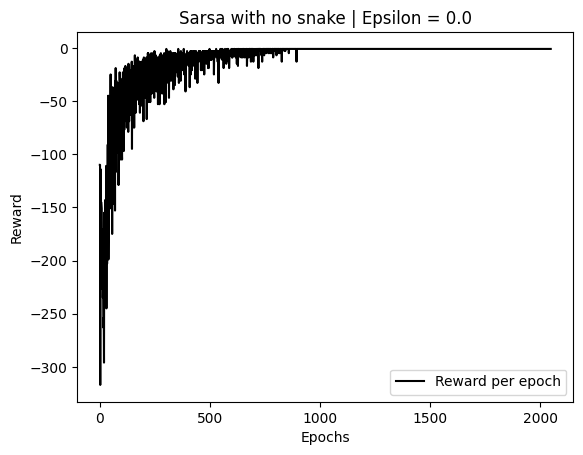

v > > > > > > > > > > > > > > > > > > > v
> > > > > > > > > > > > > > > > > > > > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


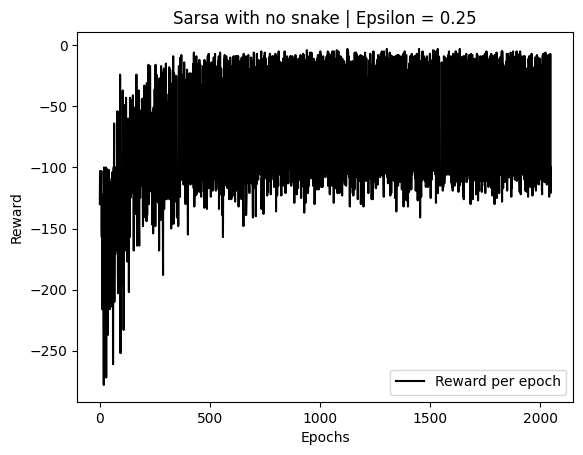

> > > > > > > > > > > > > > > > > > > > v
> > > > > > > > > > > > > > ^ ^ < > > < v
^ > > > > > > ^ > > > > > > > > > > ^ > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


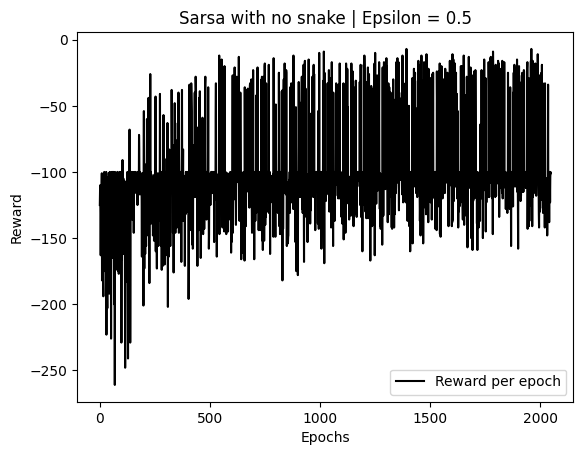

> > > > > > > > > > > > > > > > > > > > v
> > > > > > > > > > > > > > > > > ^ ^ > v
> > > > > > > > > > > > < > > > > ^ > ^ v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


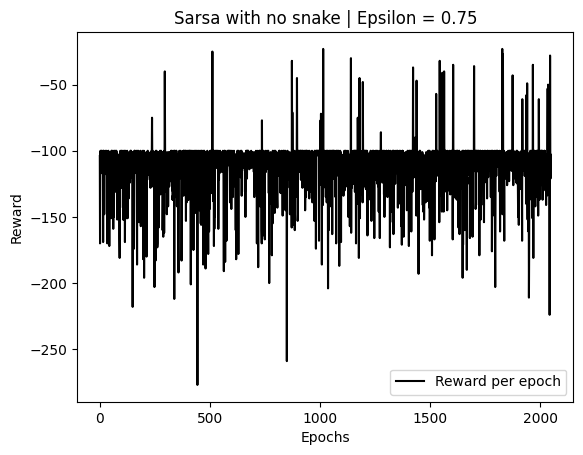

> > > > > > > > > > ^ > > > > > > > > ^ v
> > > > > > > > > > > > > > > > > > ^ > v
> > > > > > > > > > > > > > > > > > > < v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


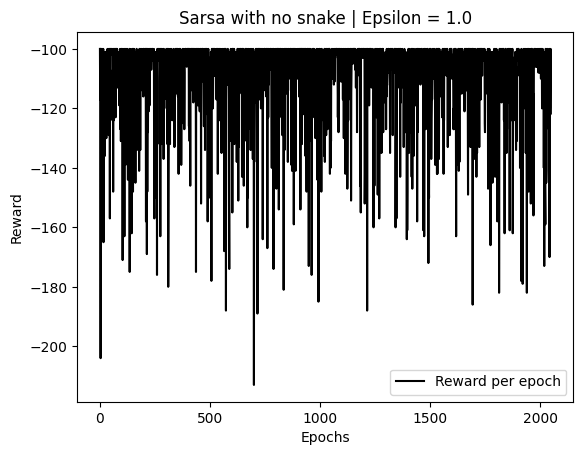

> > > > > > > > ^ > > < ^ ^ ^ ^ ^ ^ ^ ^ ^
> > > > > > > > ^ > > v ^ v < ^ ^ ^ ^ ^ ^
> > > > > > > > > > < > ^ v v v v ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [36]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_sarsa(epochs=epochs, epsilon=epsilon)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Sarsa with no snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=False)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)

### Q learning with no replay buffer and no snake

- We notice that in this case for smaller epsilon values, the agent manages to find the `optimal path` to the goal.
- We observe that for any values of epsilon, the agent is always trying to construct the most `optimal path`.
- For higher values of epsilon, the agent fails to construct a viable policy because is `falling down` the cliff most of the times. That thing will change when we add replay buffer.

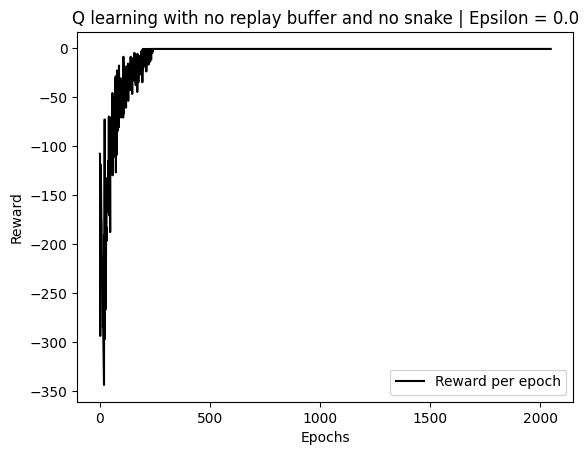

^ ^ < > > > v v ^ v > v > > v > v v > > v
> > > > v v > v > v > v v > v > v v v > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


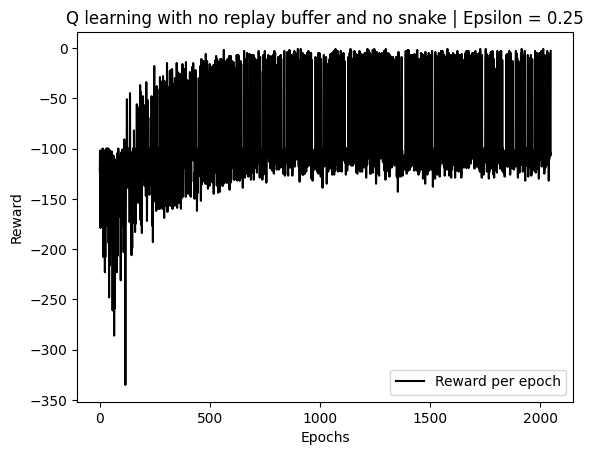

v > v v v v v > > v v v v v v v v v > v v
v > v v > > > > > > > > v > > v v v > > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


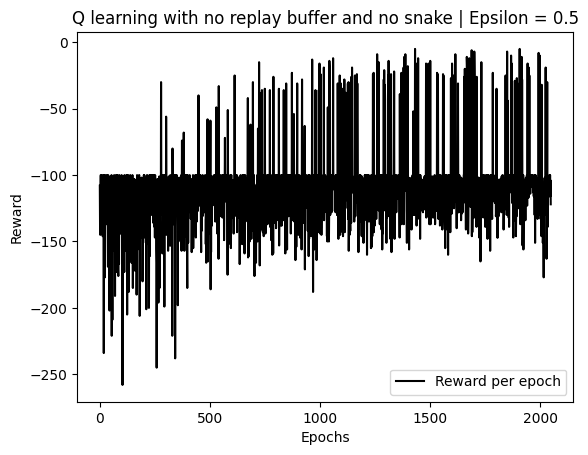

> v > > > > > > > > > > > v > v v v v v v
> > > > > > > > > > > > > > > v > v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


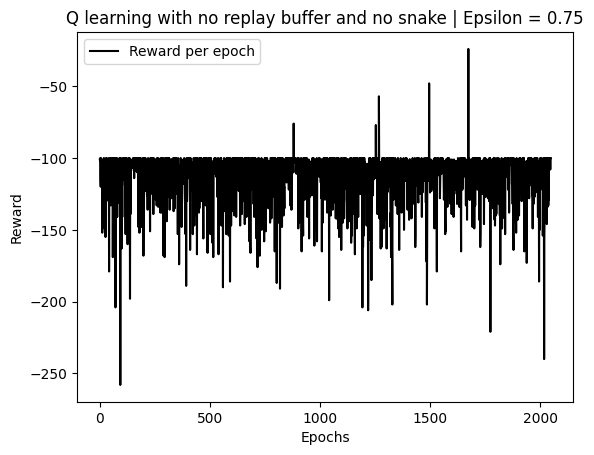

> > > > > > > > > > > > > v > ^ v > < > ^
> > > > > v > v > > v > > v v > v v v > v
> > > > > > > > > > > ^ > > > > < < > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


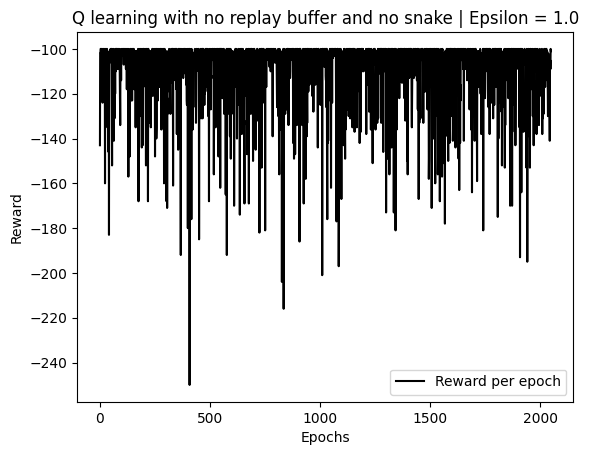

> > > > v v > > v v v < > ^ ^ ^ ^ ^ ^ ^ ^
> > > v v v v > > v < > ^ < ^ ^ ^ ^ ^ ^ ^
> > > > > > > < < > < ^ ^ < ^ v ^ ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [37]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_q_learning(epochs=epochs, epsilon=epsilon, replay_buffer_enabled=False, with_snake_pit=False)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Q learning with no replay buffer and no snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=False)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)

### Q learning with replay buffer and no snake

- Replay buffer is an element of stability to Q-learning execution.
- We observe that for a high value of epsilon = 0.75 the agent managed to find a viable (in particular, optimal) policy to the goal state.
- Clearly, replay buffer is an improvement to the normal version, but for epsilon = 1, it didn't manage to construct the proper policy. The reasons for that are:
  - `Chance`, because due to a completely random exploration, it might just happen (Given 2048 epochs) for the agent to never find the path to the goal state.
  - `Replay buffer hyperparameters` (REPLAY_BUFFER_SIZE = 2048, REPLAY_BUFFER_BATCH_SIZE = 1024). I argue that by fine tuning replay buffer's hyperparameters and by experimenting some epochs in which the agent manages to find a way to the goal under the complete randomness of epsilon=1, then a proper policy might be derived.

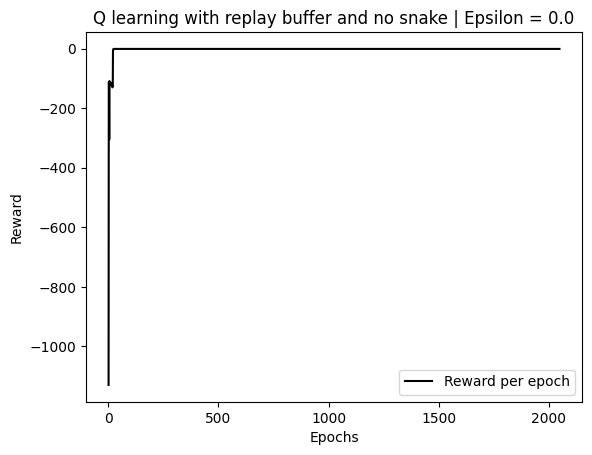

v v v v v v v v v v v v v v v v v v v v v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


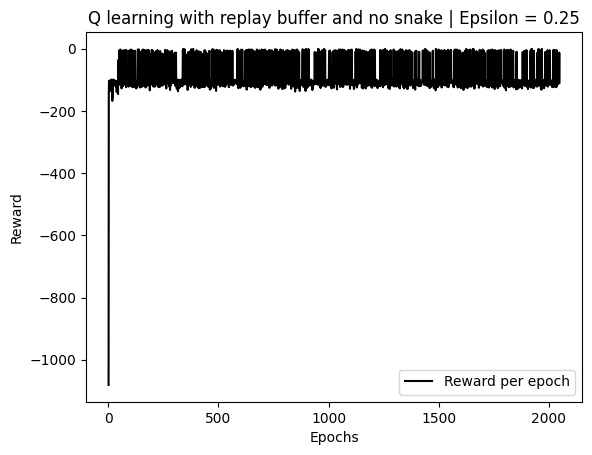

v v v > v v v v v v v v v v v v v v v v v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


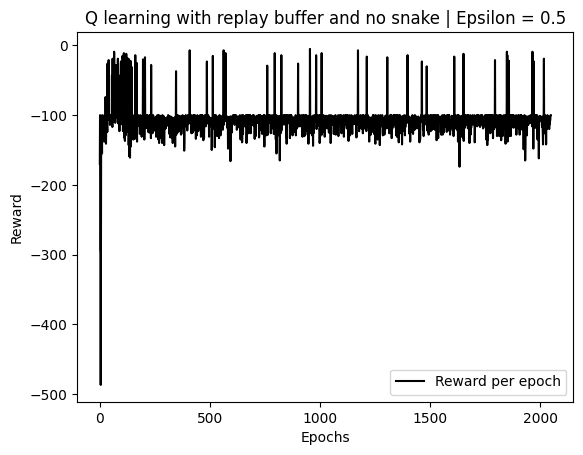

v v v v v v v v v v v v v v v v v v v v v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


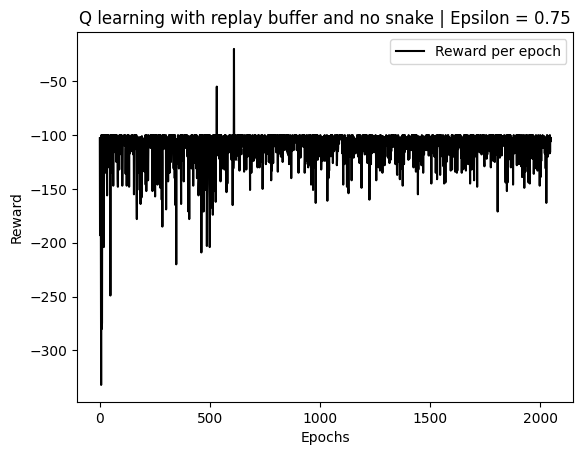

v v v v v v v v v v v v v v v v v v v > v
v v v v v v v v v v v v v v > v v v > v <
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


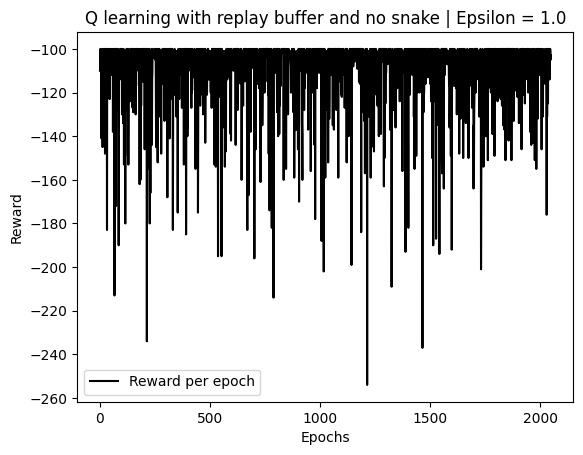

v v v v v v v v v v > ^ < ^ ^ ^ ^ ^ ^ ^ ^
v v v v v v v v v v v ^ > ^ ^ ^ ^ ^ ^ ^ ^
> > > > > > > > > < ^ > ^ ^ ^ ^ ^ ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [38]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_q_learning(epochs=epochs, epsilon=epsilon, replay_buffer_enabled=True, with_snake_pit=False)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Q learning with replay buffer and no snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=False)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)

### Sarsa with snake

- Adding the snake created some disturbances around its position, but the agent is still managing to derive the right `safe policy` for small values of epsilon.
- For high values of epsilon we experience the same situation as in with no snake situation.

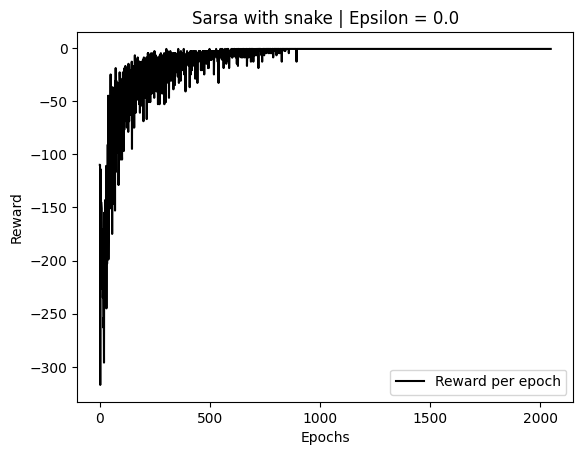

v > > > > > > > > > > P > > > > > > > > v
> > > > > > > > > > > > > > > > > > > > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


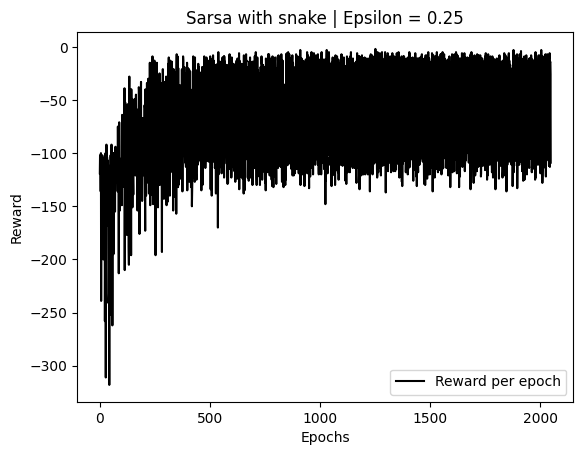

> > > < > > > > > > > P > > > > > > > > v
< > > ^ > > ^ > > > > > > > > ^ > > > > v
> > > > > > > > > > ^ > > > > ^ > > ^ > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


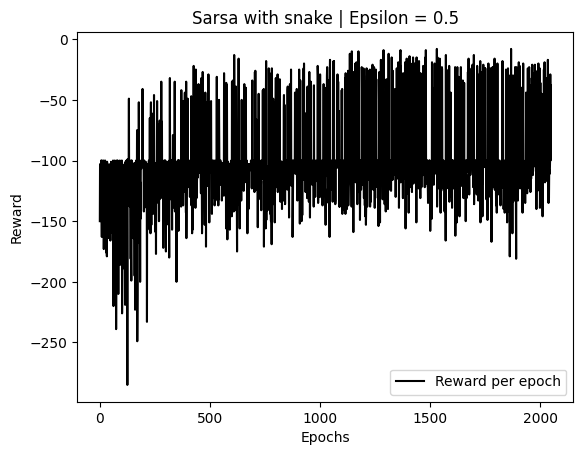

< > ^ < ^ > > > > > > P > > > > > > > > v
^ > > > > > > > > > > > > > > < > > > > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


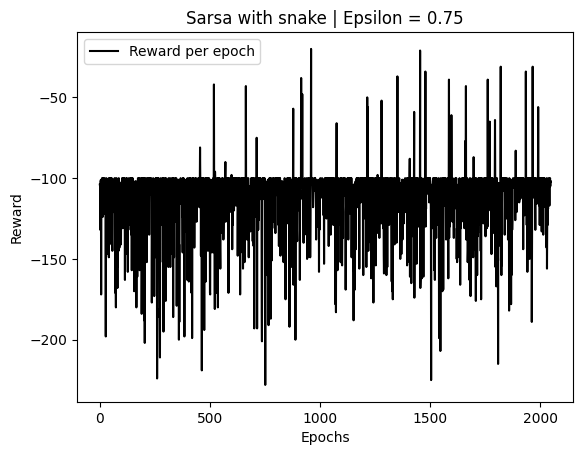

> > > > > > > > > > > P > > > > > > > > v
> > > > > > > > > > > > > > > > > > < ^ v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


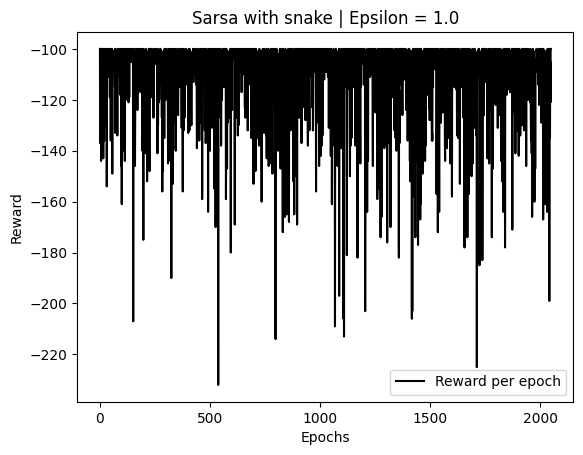

> > > > > > > ^ > ^ > P v > ^ ^ v ^ ^ ^ ^
> > > > > > > > > > < < > > ^ ^ ^ ^ ^ ^ ^
> > > > > > > ^ > > ^ ^ > > ^ ^ ^ ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [39]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_sarsa(epochs=epochs, epsilon=epsilon, with_snake_pit=True)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Sarsa with snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=True)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF, SNAKE_PIT]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)

### Q learning with no replay buffer and with snake

- We observe that the snake doesn't affect the agent's ability to derive the `optimal policy` to the goal state.
- For higher values of epsilon (same case as before), the agent (arguably, falls down the cliff) fails to construct an appropriate policy to the goal state.

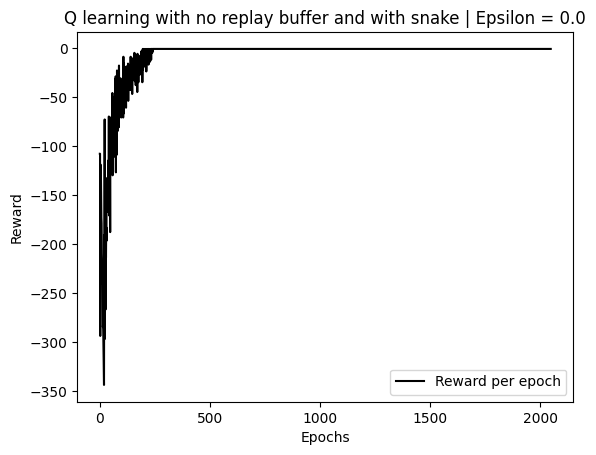

^ ^ < > > > v v ^ v > P > > v > v v > > v
> > > > v v > v > v > v v > v > v v v > v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


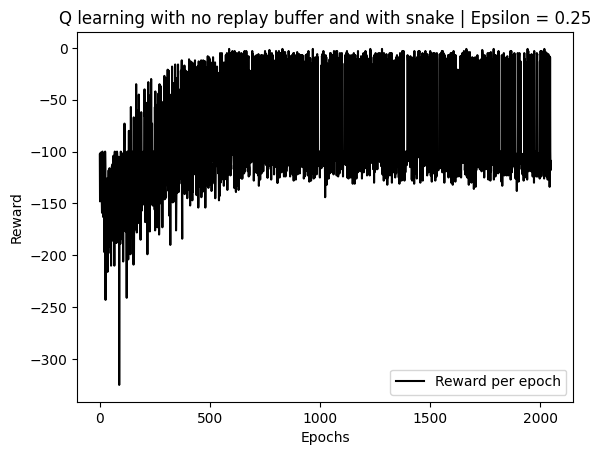

v v > v v v > v v v > P > > v v v v v v v
v > > > > > > > > > > > > > > > v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


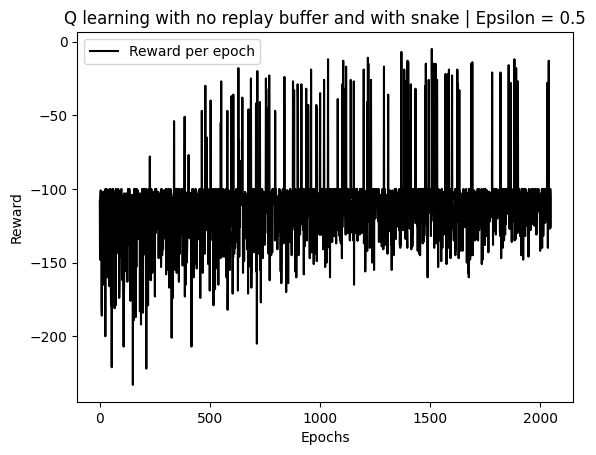

v v > > > > > > > > > P v v v v v > v v v
> v > > > > > v > > > > v v > v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


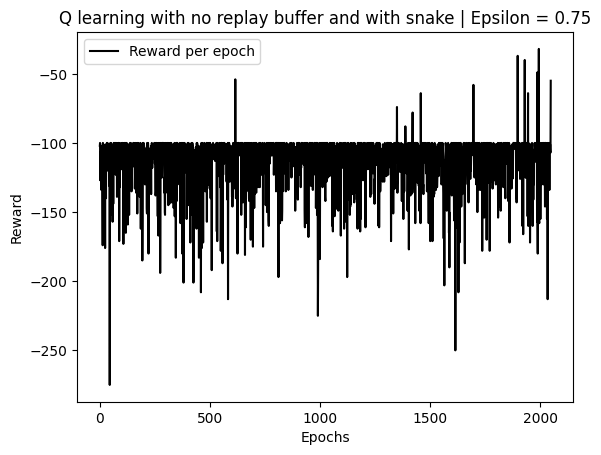

> > > > > > > > > > v P > > > v v ^ v > v
> > > > > > > v v v > > > > v > > ^ > v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


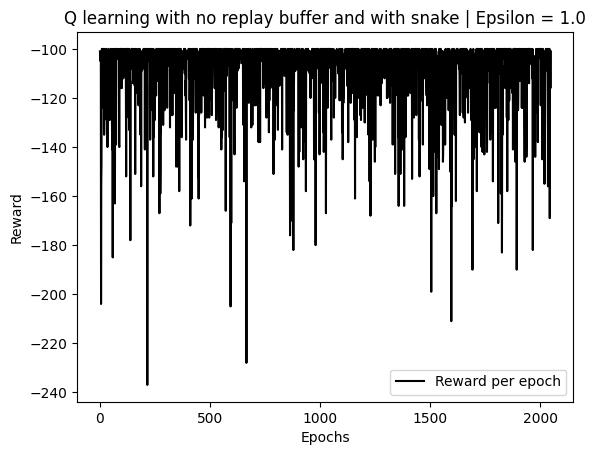

> > > > > > > > > v v P v ^ ^ ^ ^ ^ ^ ^ ^
> > > v v v v v v ^ v ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
> > > > > > > > < > ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [40]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_q_learning(epochs=epochs, epsilon=epsilon, replay_buffer_enabled=False, with_snake_pit=True)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Q learning with no replay buffer and with snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=True)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF, SNAKE_PIT]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)

### Q learning with replay buffer and with snake

 - Same situation as before, the agent manages to construct the `optimal policy` under low values of epsilon.
 - The snake pit seems to not have any quantifiable effect on the policy derivation process.
 - Under bigger values of epsilon, the same problems(`Chance` and `Hyperparameters`) prevent the agent to derive a `valid policy`.

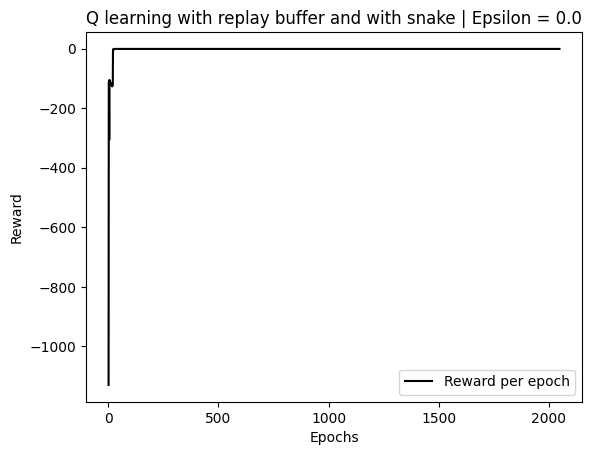

v v v v v v v v v v v P v v v v v v v v v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


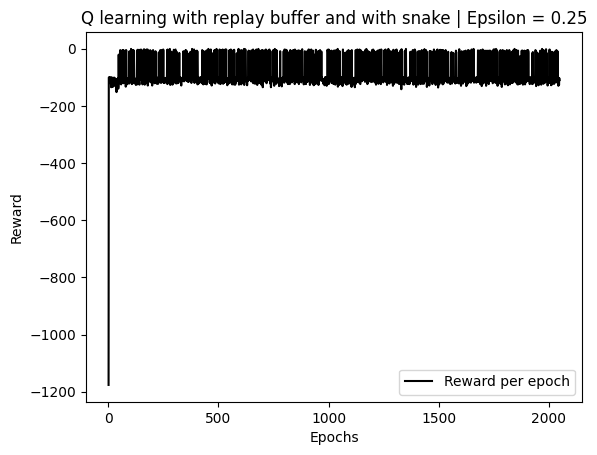

v v v v v v v v v v v P v v v v v v v v v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


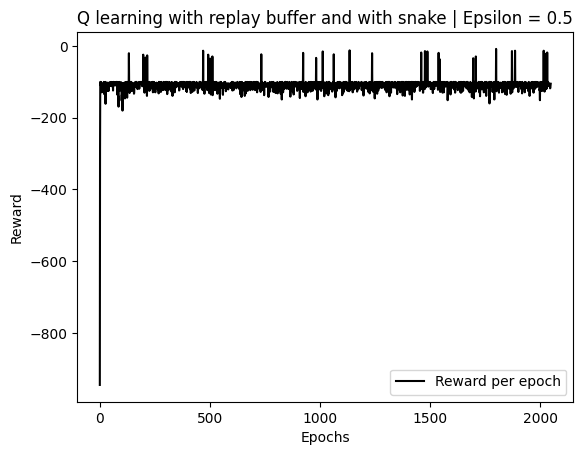

v v v v v v v v v v v P v v v v v v v > v
v v v v v v v v v v v v v v v v v v v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


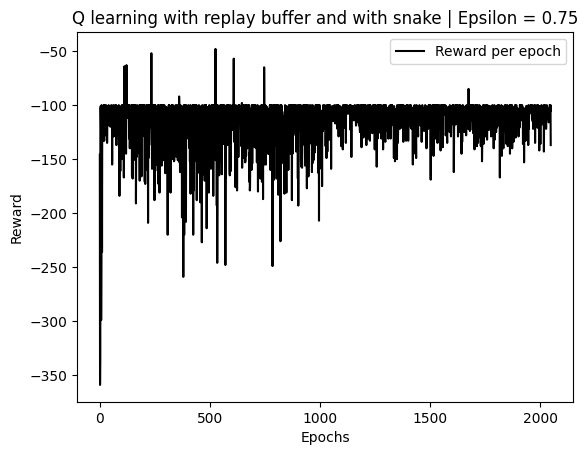

v v v v v v v v v v v P v v v v v v v v v
v v v v v v v v v v v v v v v v v > v v v
> > > > > > > > > > > > > > > > > > > > v
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


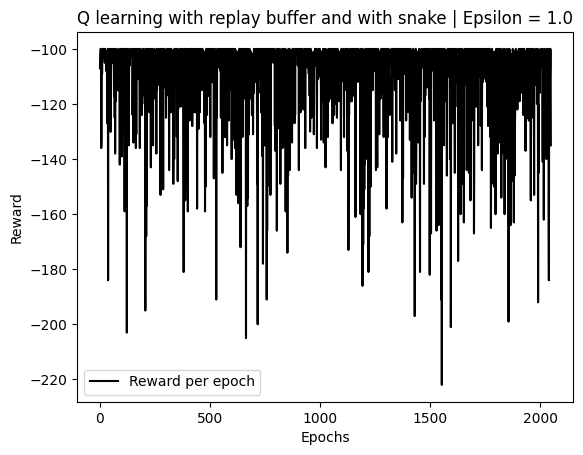

v v v v v v v v v ^ > P ^ ^ ^ ^ ^ ^ ^ ^ ^
v v v v v v v v v v v v v ^ ^ ^ ^ ^ ^ ^ ^
> > > > > > > > > > > < < ^ ^ ^ ^ ^ ^ ^ ^
S C C C C C C C C C C C C C C C C C C C G
--------------------------------------------------------------------------------


In [41]:
epochs = 2048
x = np.linspace(1, epochs, epochs)

for epsilon in [0.0, 0.25, 0.5, 0.75, 1.0]:
    Q, rewards_history = run_q_learning(epochs=epochs, epsilon=epsilon, replay_buffer_enabled=True, with_snake_pit=True)
    # Plot rewards
    plt.plot(x, rewards_history, color='black', label=f"Reward per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f"Q learning with replay buffer and with snake | Epsilon = {epsilon}")
    plt.show()

    world = get_world(with_snake_pit=True)
    for position in Q:
        actions_utilities = Q[position]
        if world[position[0]][position[1]] not in [GOAL, START, CLIFF, SNAKE_PIT]:
            world[position[0]][position[1]] = ACTIONS[np.argmax(actions_utilities)]
    
    # Printing world
    print_world(world)

    print("-" * 80)